In [239]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import random
from IPython import display
from sklearn import datasets, preprocessing

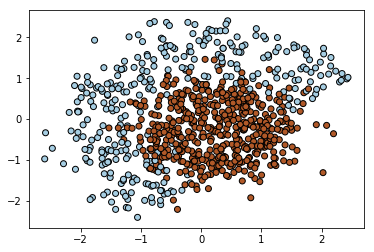

In [240]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = (y==1) | (X[:,1] > X[:,0] - 0.5)

X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
plt.show()

X, y = torch.FloatTensor(X), torch.FloatTensor(y)

In [241]:
import numpy as np

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, loss, n_iter):    
    plt.clf()
    xy = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    Z = classify(xy, w)
    
    Z = Z.numpy()
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [242]:
def expand(X):
    prod = X[:,0] * X[:,1]
    prod = prod.unsqueeze(1)
    oness = torch.ones_like(X[:, 0])
    oness = oness.unsqueeze(1)
    res = torch.cat([X, X ** 2, prod, oness], dim=1)
    return torch.FloatTensor(res)

In [243]:
def classify(X, w):
    """
    Given feature matrix X [n_samples,2] and weight vector w [6],
    return an array of +1 or -1 predictions
    """
    return torch.sign(torch.matmul(expand(X), w.unsqueeze(1)))[:, 0]


In [244]:
def  compute_loss (X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    X_expand = expand(X)
    L_temp =1 - y * torch.matmul(X_expand, w.unsqueeze(1))[:, 0]
    L_temp[L_temp < 0] = 0
    return L_temp.sum(0).item() / len(L_temp)


def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    X_expand = expand(X)
    der = torch.zeros_like(X_expand)
    indx = (y * torch.matmul(X_expand, w.unsqueeze(1))[:, 0]) < 0
    der[indx] = - y[indx].unsqueeze(1) * X_expand[indx]
    return der.sum(0) / len(X_expand)
    

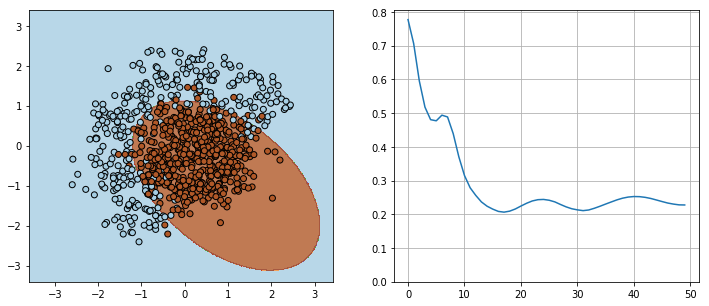

In [249]:
w = torch.Tensor([1,  0,  0,  0,  0,  0])

alpha = 0.4
mu  =  0.99

v = torch.zeros_like(w)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)
    
    v = mu * v  - alpha * compute_grad(X, y, w)
    w = w + v

visualize(X, y, w, loss, n_iter)
plt.clf()

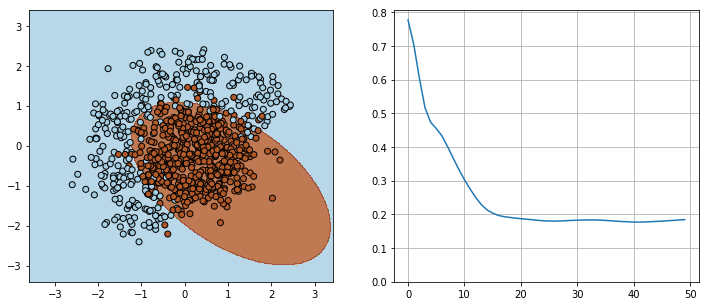

In [248]:
w = torch.Tensor([1, 0, 0, 0, 0, 0])

alpha = 0.4
mu    = 0.99

v = torch.zeros_like(w)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)
    v = v * mu - alpha * compute_grad(X, y, w + v * mu)
    w = w + v

visualize(X, y, w, loss, n_iter)
plt.clf()


Finally, try Adam algorithm. You can start with beta = 0.9 and mu = 0.999

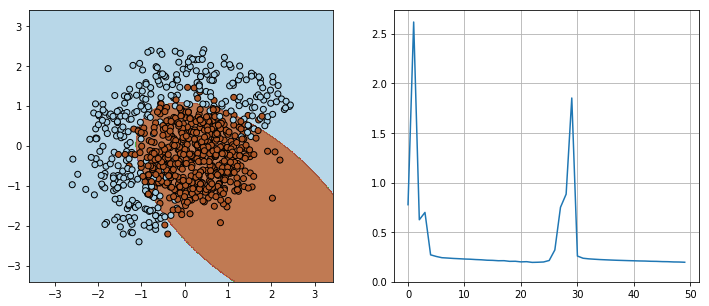

In [250]:
import random 


w = torch.Tensor([1, 0, 0, 0, 0, 0])

alpha = 0.4
beta = 0.9
mu = 0.999
eps = 1.e-7

v = torch.zeros_like(w)
g = torch.zeros_like(w)


n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)
    grad = compute_grad(X, y, w)
    
    v = v * beta + (1 - beta) * grad
    g = mu * g + (1 - mu) * torch.dot(grad, grad)
    w = w - alpha / (torch.sqrt(g) + eps) * grad 

visualize(X, y, w, loss, n_iter)
plt.clf()